In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    geno_palette,
    syllable_aliases,
    savefig,
    plot_pval,
    clean_ticks
)
from rl_analysis.batch import apply_parallel_joblib
from rl_analysis.behavior.util import get_stim_effects
from rl_analysis.info.util import dm_entropy
from rl_analysis.io.df import get_closed_loop_parquet_columns
from scipy.stats import mannwhitneyu
from functools import partial
from statsmodels.stats.multitest import multipletests

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
convs = {
    "timestamp": "float32",
    "snippet": "int64",
    "syllable": "category",
    "next_syllable": "uint8",
    "bin": "int32",
    "time_bin": "float32",
    "dlight_bin": "category",
    "mouse_id": "category",
    "uuid": "category",
    "counts": "uint16",
}

In [4]:
regress_scalars = [
    "velocity_2d_mm",
    "velocity_angle",
    "velocity_height",
    "acceleration_2d_mm",
]

## Load in pre-processed data

In [5]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [6]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

In [7]:
force = False

In [8]:
results_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "realtime_effects_entropy_and_scalars.parquet"
)
results_tm_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "realtime_effects_entropy_and_scalars_tms.npy"
)

# Load in raw data if needed

In [9]:
fname = os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet")
cols = get_closed_loop_parquet_columns(fname, pcs=False, likes=False) 

In [10]:
feedback_df = pd.read_parquet(
    fname,
    filters=[
        [("experiment_type", "=", "reinforcement")],
        [("experiment_type", "=", "excitation")],
        [("experiment_type", "=", "excitation_pulsed")],
    ],
    columns=cols,
).sort_index()

feedback_df.rename(
    columns={
        "predicted_syllable": "syllable",
        "predicted_syllable_number": "syllable_number",
    },
    inplace=True,
)
feedback_df = feedback_df.loc[
    (feedback_df["area"].isin(["ctrl", "snc (axon)"]))
    & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
    & (feedback_df["session_number"].isin([1, 2]))
].copy()

In [11]:
feedback_df.index = range(len(feedback_df))

In [12]:
rle_df = feedback_df.drop_duplicates(["uniq_id", "syllable_number"]).copy()

In [13]:
usage = rle_df.groupby("uniq_id")["syllable"].value_counts().groupby("syllable").mean()
mapping = dict(list(zip(usage.index, np.arange(len(usage)))))

In [15]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "syllable_stats_online.toml")
)

In [16]:
rle_df["syllable_original_id"] = rle_df["syllable"]
rle_df["target_syllable_original_id"] = rle_df["target_syllable"]
rle_df["syllable"] = rle_df["syllable"].map(mapping)
rle_df["target_syllable"] = rle_df["target_syllable"].map(mapping)

In [17]:
feedback_df["is_feedback"] = feedback_df["feedback_status"] == 1
feedback_df["is_catch"] = feedback_df["feedback_status"] == 0

fbacks = (
    feedback_df.groupby(["uniq_id", "syllable_number"])["is_feedback"]
    .any()
    .sort_index()
)
catches = (
    feedback_df.groupby(["uniq_id", "syllable_number"])["is_catch"].any().sort_index()
)

In [18]:
# look ahead one/two syllables in case feedback was delayed

max_lookahead = 1
fbacks_base = fbacks.copy()
for i in range(-max_lookahead, max_lookahead + 1):
    fbacks_base |= fbacks.groupby("uniq_id").shift(-i)

catches_base = catches.copy()
for i in range(-max_lookahead, max_lookahead + 1):
    catches_base |= catches.groupby("uniq_id").shift(-i)

In [19]:
try:
    rle_df = rle_df.set_index(["uniq_id", "syllable_number"]).sort_index()
except KeyError:
    pass

In [20]:
rle_df.drop(["is_feedback", "is_catch"], axis=1, errors="ignore", inplace=True)

In [21]:
rle_df = rle_df.join(fbacks_base).join(catches_base)
rle_df.loc[rle_df["syllable"] != rle_df["target_syllable"], "is_feedback"] = False
rle_df.loc[rle_df["syllable"] != rle_df["target_syllable"], "is_catch"] = False

# Stage data for downstream computation

In [24]:
scalar_df = (
    feedback_df.groupby(["uniq_id", "syllable_number"])[regress_scalars]
    .mean()
    .sort_index()
)
rle_df.drop(regress_scalars, axis=1, errors="ignore", inplace=True)

rle_df = rle_df.join(scalar_df)
rle_df = rle_df.reset_index()

rle_df["stim_status"] = "n/a"
rle_df.loc[rle_df["is_feedback"], "stim_status"] = "stim"
rle_df.loc[rle_df["is_catch"], "stim_status"] = "catch"
rle_df["duration"] = rle_df.groupby("uniq_id")["timestamp"].transform(
    lambda x: x.diff().shift(-1)
)

In [25]:
rle_df = rle_df.loc[rle_df["session_number"].isin([1, 2])].copy()

In [26]:
rle_df = rle_df.reset_index()

In [27]:
mapping = rle_df.drop_duplicates("syllable").set_index("syllable_original_id")[
    "syllable"
]
reverse_mapping = rle_df.drop_duplicates("syllable").set_index("syllable")[
    "syllable_original_id"
]

In [28]:
mapping = mapping.to_dict()
reverse_mapping = reverse_mapping.to_dict()

# Now we compute values triggered on syllable instances, storing features we want to split by downstream (dLight, scalars, etc.)

In [30]:
usage_bins = np.concatenate([np.arange(5, 52, 5)])
usage_bins = sorted(np.concatenate([-usage_bins, usage_bins]))

In [31]:
scalar_keys = rle_df.filter(regex=".*(2d_mm|angle|height)").columns.tolist()

In [32]:
if (not os.path.exists(results_file)) or force:
    group_obj = rle_df.loc[(rle_df["session_number"].isin([1, 2]))].groupby("uuid")
    targets = [mapping[_] for _ in syllable_aliases.keys()]

    func = partial(
        get_stim_effects,
        chk_syllables=targets,
        truncate=syllable_stats["truncate"],
        additional_scalar_keys=regress_scalars + ["duration"],
        additional_syllable_keys=["duration"],
        usage_bins=usage_bins,
        K=int(rle_df["syllable"].max() + 1),
    )

    print(group_obj.ngroups)
    syllable_rates = apply_parallel_joblib(group_obj, func, n_jobs=-1, backend="loky")
    syllable_rates = syllable_rates.reset_index()

    for k, v in tqdm(convs.items()):
        try:
            syllable_rates[k] = syllable_rates[k].astype(v)
        except KeyError:
            pass

    save_rates = syllable_rates[syllable_rates.columns.difference(["tm"])]
    tm_list = syllable_rates["tm"].to_list()
    meta_df = rle_df.drop_duplicates("mouse_id").set_index("mouse_id")["area"]
    save_rates.to_parquet(results_file)
    np.save(results_tm_file, tm_list)
else:
    save_rates = pd.read_parquet(results_file)
    tm_mat = np.load(results_tm_file)
    tm_list = list(tm_mat)
save_rates["tm"] = tm_list

522


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 320 out of 522 | elapsed:   24.8s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done 373 out of 522 | elapsed:   26.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 426 out of 522 | elapsed:   28.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 479 out of 522 | elapsed:   31.

  0%|          | 0/11 [00:00<?, ?it/s]

# Compute correlations

In [33]:
learner_dct = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml")
)
learners = []
for k, v in learner_dct.items():
    learners += v["learners"]

In [34]:
use_syllable_rates = save_rates.copy()

use_syllable_rates = use_syllable_rates.loc[
    (
        use_syllable_rates["experiment_type"].isin(
            ["reinforcement", "excitation", "excitation_pulsed"]
        )
    )
].copy()

idx = pd.IndexSlice

use_syllable_rates["uuid"] = use_syllable_rates["uuid"].astype("str")

In [35]:
# number of quantile bins for dlight data

# first aggregation to reduce data size
pre_agg_keys = [
    "uuid",
    "target_syllable_original_id",
    "area",
    "bin",
    "stim_status",
    "stim_duration",
    "mouse_id",
]
agg_keys = [
    "stim_status",
    "target_syllable_original_id",
    "stim_duration",
    "area",
    "bin",
    "uuid",
    "mouse_id",
]

In [36]:
# aggregation one
agg_rates = (
    use_syllable_rates.groupby(pre_agg_keys, observed=True)["tm"].sum().sort_index()
)
agg_rates_sz = (
    use_syllable_rates.groupby(pre_agg_keys, observed=True).size().sort_index()
)

In [37]:
# need to reconvert data types to conserve memory
for k, v in tqdm(convs.items()):
    try:
        agg_rates[k] = agg_rates[k].astype(v)
    except KeyError:
        pass

  0%|          | 0/11 [00:00<?, ?it/s]

In [38]:
truncate = syllable_stats["truncate"]

In [39]:
totals_trim = agg_rates.apply(lambda x: x[:truncate, :truncate].sum())
use_syllables = totals_trim[totals_trim > 100].index  

In [40]:
# ensure we have all bins
use_rates = agg_rates.loc[use_syllables]
chk_keys = list(set(pre_agg_keys[:-1]) - set(["dlight_bin"]))

In [41]:
ents = use_rates.apply(
    lambda x: dm_entropy(
        x[:truncate, :truncate], alpha="perks", marginalize=False, axis=1
    )
).rename("entropy")

In [42]:
use_rates = pd.concat((use_rates, ents), axis=1)
use_rates = use_rates.reset_index()

In [43]:
idx = pd.IndexSlice

In [44]:
pre_rates = use_rates[use_rates["bin"] < 0].copy()
pre_rates["bin"] *= -1

In [45]:
pre_stim_mu = pre_rates.groupby(agg_keys).mean(numeric_only=True)
pre_stim_sig = pre_rates.groupby(agg_keys).std(numeric_only=True)
post_stim_mu = use_rates.groupby(agg_keys).mean(numeric_only=True)
stim_sz = agg_rates_sz.groupby(agg_keys).sum(numeric_only=True)

In [46]:
from sklearn.utils import resample

In [47]:
zstim_mu = (post_stim_mu - pre_stim_mu).dropna()
zstim_mu["sz"] = stim_sz
bins = sorted(zstim_mu.index.get_level_values("bin").unique())

In [48]:
check_durations = [0.25, 2, 3]
check_areas = ["snc (axon)", "snc (axon, dms)", "ctrl"]
dcts = []
use_test = mannwhitneyu
for _duration in check_durations:
    for _bin in bins:
        for _area in check_areas:
            try:
                dat1 = zstim_mu.xs(
                    ("catch", _bin, _area, _duration),
                    level=("stim_status", "bin", "area", "stim_duration"),
                )["entropy"]
                dat2 = zstim_mu.xs(
                    ("stim", _bin, _area, _duration),
                    level=("stim_status", "bin", "area", "stim_duration"),
                )["entropy"]
            except KeyError:
                continue
            try:
                stat, pval = use_test(
                    dat1,
                    dat2,
                )
            except ValueError:
                pass
            _dct = {
                "duration": _duration,
                "bin": _bin,
                "pval": pval,
                "stat": stat,
                "area": _area,
                "n1": len(dat1),
                "n2": len(dat2),
                "test": str(use_test.__name__),
            }
            dcts.append(_dct)
pval_df = pd.DataFrame(dcts)

In [49]:
pval_df["pval"] = pval_df.groupby(["duration", "area"])["pval"].transform(
    lambda x: multipletests(x, method="holm")[1]
)

### Compute change in transition entropy

In [50]:
nshuffles = 1000
alpha = 0.68
use_func = "mean"

In [51]:
group_keys = [
    "stim_status",
    "stim_duration",
    "area",
    "bin",
]

In [52]:
if isinstance(use_func, str):
    catch_shuffles = pd.concat(
        [
            resample(zstim_mu)
            .groupby(group_keys)["entropy"]
            .apply(use_func)
            .loc["catch"]
            for _ in tqdm(range(nshuffles))
        ],
        axis=1,
    )
else:
    catch_shuffles = pd.concat(
        [
            resample(zstim_mu).groupby(group_keys).apply(use_func).loc["catch"]
            for _ in tqdm(range(nshuffles))
        ],
        axis=1,
    )
catch_mu = catch_shuffles.mean(axis=1)
catch_sig = catch_shuffles.std(axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
if isinstance(use_func, str):
    zshuffle_mus = [
        (
            resample(zstim_mu)
            .groupby(group_keys)["entropy"]
            .apply(use_func)
            .loc["stim"]
            - catch_mu
        )
        / catch_sig
        for _ in tqdm(range(nshuffles))
    ]
else:
    zshuffle_mus = [
        (resample(zstim_mu).groupby(group_keys).apply(use_func).loc["stim"] - catch_mu)
        / catch_sig
        for _ in tqdm(range(nshuffles))
    ]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
zcatch_shuffle_df = catch_shuffles.apply(lambda x: (x - catch_mu) / catch_sig)
chance = zcatch_shuffle_df.abs().quantile(0.95, axis=1)
chance = chance.max()

In [55]:
zshuffle_df = pd.concat(zshuffle_mus, 1)
stim_compare = zstim_mu.groupby(group_keys).mean()["entropy"].loc["stim"]
catch_compare = catch_shuffles.melt(ignore_index=False, value_name="entropy").drop(
    "variable", axis=1
)

/tmp/ipykernel_1381995/3673737663.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  zshuffle_df = pd.concat(zshuffle_mus, 1)
/tmp/ipykernel_1381995/3673737663.py:3: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  catch_compare = catch_shuffles.melt(ignore_index=False, value_name="entropy").drop(


In [56]:
catch_compare = catch_compare.loc[catch_compare.index.intersection(stim_compare.index)]
stim_compare = stim_compare.loc[catch_compare.index]

In [58]:
setup_plotting_env()
sns.set_context("paper")

In [59]:
plt_duration = 0.25
plt_areas = ["snc (axon)", "snc (axon, dms)", "ctrl"]
palette = [geno_palette.snc, geno_palette.vta, geno_palette.ctrl]

In [60]:
ci_df = zshuffle_df.quantile([0.5 + alpha / 2, 0.5 - alpha / 2], axis=1)
ave_df = zstim_mu.groupby(group_keys).mean()["entropy"].loc["stim"]
zave_df = (ave_df - catch_mu) / catch_sig

In [61]:
alpha_thresh = 0.05
continuity_thresh = 0

In [62]:
setup_plotting_env()

In [63]:
duration = np.around(float(syllable_stats["duration"]["median"]), 1)

In [64]:
plt_pval_df = pval_df.set_index(["bin", "duration", "area"])["pval"].sort_index()

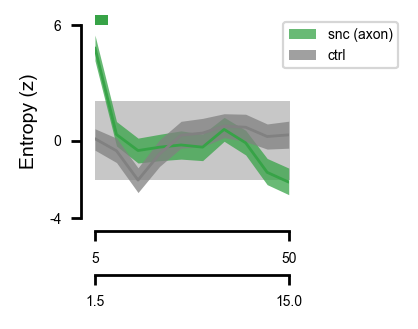

In [65]:
fig, ax = plt.subplots(1, figsize=(1.25, 1.25))
for _area, _color in zip(plt_areas, palette):
    try:
        lo = ci_df[(plt_duration, _area)].iloc[0]
        hi = ci_df[(plt_duration, _area)].iloc[1]
    except KeyError:
        continue
    idx = lo.index
    ax.fill_between(idx, lo, hi, fc=_color, alpha=0.75, ec=None, lw=0, label=_area)
    ax.plot(
        zave_df.xs((plt_duration, _area), level=("stim_duration", "area")), color=_color
    )
    ax.fill_between(
        ax.get_xlim(),
        -chance,
        +chance,
        facecolor=[0.5] * 3,
        edgecolor=None,
        lw=0,
        alpha=0.25,
        zorder=-600,
    )

ax.set_xlim(5, 50)
ax.set_ylim(-4, 6)
sns.despine()
clean_ticks(ax, "y", precision=0, dtype=int, zero_symmetry=False)
clean_ticks(ax, "x", precision=0, dtype=int, zero_symmetry=False)

keys = plt_areas
key_level = "area"
use_colors = palette

try:
    plot_pval(
        plt_pval_df.xs(plt_duration, level="duration"),
        keys,
        key_level,
        ax=ax,
        colors=use_colors,
        offset=1.0,
        height=0.05,
        spacing=1.3,
        min_width=3,
        alpha_threshold=alpha_thresh,
        continuity_threshold=continuity_thresh,
    )
except (KeyError, NameError):
    pass

syllables_to_time = lambda x: x * duration
time_to_syllables = lambda x: x / duration

secax_x = ax.secondary_xaxis(-0.3, functions=(syllables_to_time, time_to_syllables))
secax_x.set_ticks([syllables_to_time(5), syllables_to_time(50)])

sns.despine(offset=5)
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.ylabel("Entropy (z)")
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"post_stim_entropy_{plt_areas}"),
    bbox_inches="tight",
)

## Scalars

In [67]:
scalar_keys = [
    "velocity_2d_mm_bin",
    "acceleration_2d_mm_bin",
    "velocity_angle_bin",
    "velocity_height_bin",
]

In [68]:
from numba import jit

cache = False


@jit(nopython=True, cache=cache)
def zscore_nb(values, index):
    return (values - np.nanmean(values)) / np.nanstd(values)

In [69]:
# between syllables

z_features = scalar_keys
regress_df = use_syllable_rates.copy()
z_keys_between = ["uuid"]
zscore_data = True
if zscore_data:
    regress_df[z_features] = regress_df.groupby(z_keys_between)[z_features].transform(
        zscore_nb, engine="numba"
    )

In [70]:
pre_agg_keys = [
    "uuid",
    "mouse_id",
    "target_syllable",
    "area",
    "bin",
    "stim_status",
    "stim_duration",
]
regress_df = regress_df.groupby(pre_agg_keys, observed=True)[scalar_keys].mean()

In [71]:
scalar_cols = regress_df.filter(regex="bin$").columns

In [72]:
use_df = regress_df.reset_index()
use_df = use_df.loc[~use_df["mouse_id"].str.contains("chrimson")]

In [73]:
zstim_mu_scalars = (
    use_df.reset_index()
    .groupby(["stim_status", "area", "stim_duration", "uuid", "bin"], observed=True)[
        scalar_cols
    ]
    .mean()
)

In [74]:
nshuffles = 1000

In [75]:
shuffles = []
for i in tqdm(range(nshuffles)):
    ave = (
        resample(use_df)
        .groupby(["stim_status", "area", "stim_duration", "bin"], observed=True)
        .mean(numeric_only=True)
        .reset_index()
    )
    shuffles.append(ave)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
shuffle_df = pd.concat(shuffles)

In [77]:
shuffle_mus = (
    shuffle_df.loc[shuffle_df["stim_status"].isin(["catch"])]
    .reset_index()
    .groupby(["area", "stim_duration", "bin"], observed=True)
    .mean()
)
shuffle_sigs = (
    shuffle_df.loc[shuffle_df["stim_status"].isin(["catch"])]
    .reset_index()
    .groupby(["area", "stim_duration", "bin"], observed=True)
    .std()
)

/tmp/ipykernel_1381995/2310048742.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/tmp/ipykernel_1381995/2310048742.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .std()


In [78]:
shuffles = []
for i in tqdm(range(nshuffles)):
    ave = (
        resample(zstim_mu_scalars.loc["stim"])
        .groupby(["area", "stim_duration", "bin"])
        .mean()
        - shuffle_mus
    ) / shuffle_sigs
    shuffles.append(ave)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [79]:
chance = (
    shuffle_df.loc[shuffle_df["stim_status"] == "catch"]
    .set_index(shuffle_mus.index.names)[
        shuffle_df.columns.intersection(shuffle_mus.columns).tolist()
    ]
    .apply(lambda x: (x - shuffle_mus[x.name]) / shuffle_sigs[x.name])
    .abs()
    .quantile(0.95)
    .max()
)

In [80]:
zshuffle_df = pd.concat(shuffles)

In [81]:
dur_order = [0.25, 2, 3]

In [82]:
durs = [0.25, 2, 3]
areas = ["snc (axon)", "snc (axon, dms)", "ctrl"]
plt_colors = [geno_palette.snc, geno_palette.vta, geno_palette.ctrl]
alpha = 0.68

In [83]:
ci_lo = np.around(0.5 - alpha / 2, 3)
ci_mid = np.around(0.5, 3)
ci_hi = np.around(0.5 + alpha / 2, 3)

In [84]:
cis = zshuffle_df.groupby(["stim_duration", "area", "bin"]).quantile(
    [ci_lo, ci_mid, ci_hi]
)[scalar_cols]
cis.index = cis.index.set_names("ci", level=-1)

In [85]:
label_mapping = {
    "velocity_2d_mm_bin": "Vel.",
    "velocity_angle_bin": "Vel. ang.",
    "velocity_height_bin": "Z Vel.",
    "acceleration_2d_mm_bin": "Acc.",
}

In [86]:
indicate_stim_time = True

In [87]:
setup_plotting_env()

In [88]:
check_durations = [0.25, 2, 3]
check_areas = ["snc (axon)", "ctrl"]
dcts = []
for _duration in check_durations:
    for _key in scalar_keys:
        for _bin in bins:
            for _area in check_areas:
                try:
                    dat1 = zstim_mu_scalars.xs(
                        ("catch", _bin, _area, _duration),
                        level=("stim_status", "bin", "area", "stim_duration"),
                    )[_key]
                    dat2 = zstim_mu_scalars.xs(
                        ("stim", _bin, _area, _duration),
                        level=("stim_status", "bin", "area", "stim_duration"),
                    )[_key]
                except KeyError:
                    continue
                try:
                    stat, pval = use_test(
                        dat1,
                        dat2,
                        alternative="less",
                    )
                except ValueError:
                    continue
                _dct = {
                    "duration": _duration,
                    "scalar": _key,
                    "bin": _bin,
                    "pval": pval,
                    "stat": stat,
                    "area": _area,
                    "test": str(use_test.__name__),
                    "n1": len(dat1),
                    "n2": len(dat2),
                }
                dcts.append(_dct)
pval_df_scalars = pd.DataFrame(dcts)

In [89]:
pval_df_scalars["pval"] = pval_df_scalars.groupby(["duration", "scalar", "area"])[
    "pval"
].transform(lambda x: multipletests(x, method="holm")[1])
pval_df_scalars = pval_df_scalars.set_index(["area", "duration", "scalar", "bin"])

In [90]:
setup_plotting_env()

In [91]:
duration = np.around(float(syllable_stats["duration"]["median"]), 1)

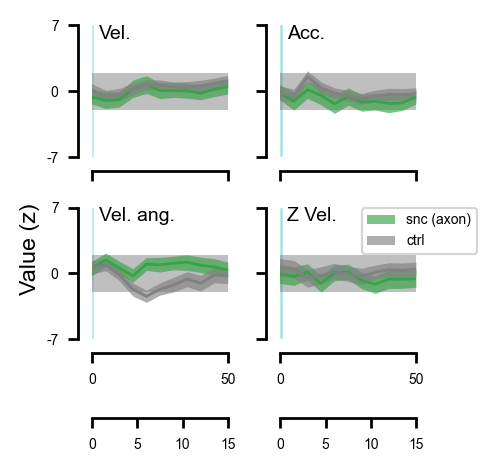

In [95]:
fig, ax = plt.subplots(
    len(scalar_cols) // 2,
    2,
    figsize=(0.85 * len(durs), 1.25 * float(len(scalar_cols) // 2)),
    sharex=True,
    sharey=True,
)
ax = ax.ravel()
use_dur = .25  # .25 and 3 are shown in Figure 3
for _ax, var in zip(ax, scalar_keys):
    use_ci = cis.xs(use_dur, level="stim_duration")[var]
    for _area, _color in zip(areas, plt_colors):
        try:
            plt_ci = use_ci.xs(_area, level="area").loc[-5:100]
        except KeyError:
            continue
        plt_ci_lo = plt_ci.xs(ci_lo, level="ci").rolling(1, 1, True).mean()
        plt_ci_hi = plt_ci.xs(ci_hi, level="ci").rolling(1, 1, True).mean()
        plt_ci_mid = plt_ci.xs(ci_mid, level="ci").rolling(1, 1, True).mean()
        _ax.fill_between(
            plt_ci_lo.index,
            plt_ci_lo.values.ravel(),
            plt_ci_hi.values.ravel(),
            alpha=0.65,
            facecolor=_color,
            edgecolor=None,
            lw=0,
            label=_area,
        )
        _ax.plot(plt_ci_lo.index, plt_ci_mid.values.ravel(), color=_color)

    _ax.text(0.05, 0.9, label_mapping[var], transform=_ax.transAxes)

    keys = areas
    key_level = "area"
    use_colors = plt_colors
    try:
        plot_pval(
            pval_df_scalars.xs((use_dur, var), level=("duration", "scalar"))["pval"],
            keys,
            key_level,
            ax=_ax,
            colors=use_colors,
            offset=1.0,
            height=0.1,
            spacing=1.3,
            min_width=3,
            alpha_threshold=alpha_thresh,
            continuity_threshold=continuity_thresh,
        )
    except (KeyError, NameError):
        continue

plt.ylim(-7, 7)
plt.xlim(0, 50)
plt.legend(bbox_to_anchor=(1.5, 1.05))

for _ax in ax.flat:
    _ax.fill_between(
        _ax.get_xlim(),
        -chance,
        +chance,
        facecolor=[0.5] * 3,
        edgecolor=None,
        lw=0,
        alpha=0.5,
        zorder=-300,
    )
    if indicate_stim_time:
        _ax.fill_between(
            [0, use_dur / duration],
            *_ax.get_ylim(),
            facecolor="c",
            alpha=0.5,
            zorder=-600,
        )


syllables_to_time = lambda x: x * duration
time_to_syllables = lambda x: x / duration

for _ax in ax[-2:]:
    # ax[0].set_xticks([0,25,50])
    secax_x = _ax.secondary_xaxis(
        -0.6, functions=(syllables_to_time, time_to_syllables)
    )
    secax_x.set_ticks(np.arange(0, 21, 5).astype("int"))

clean_ticks(ax, "y", dtype=int, zero_symmetry=False)
clean_ticks(ax, "x", zero_symmetry=False, precision=-1, dtype=int, include_zero=False)

sns.despine(offset=5)
fig.supylabel("Value (z)")
# fig.supxlabel("Time from stim (syll.)")
fig.tight_layout(rect=[-0.05, 0, 1, 1])
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"post_stim_scalars-{areas}-{use_dur}"),
    bbox_inches="tight",
)

In [93]:
import json

with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_post_stim_entropy.toml"), "w"
) as f:
    plt_json = json.loads(pval_df.to_json())
    toml.dump(plt_json, f)

In [94]:
import json

with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_post_stim_scalars.toml"), "w"
) as f:
    plt_json = json.loads(pval_df_scalars.to_json())
    toml.dump(plt_json, f)